<a href="https://colab.research.google.com/github/amirkasaei/Image-Segemntation-CamVid/blob/main/SegNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [1]:
!pip install -q torcheval

In [53]:
import torch
import tensorflow as tf
from torch import nn
from torch.utils.data import DataLoader, random_split
import torchvision
import torcheval
from torcheval.metrics.functional import binary_accuracy
from torchvision import transforms
from torchvision.transforms import ToTensor, ToPILImage, Normalize

# PyTorch TensorBoard support
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.model_selection import KFold

import copy
import imageio
import PIL.Image as Image

import os
import sys
import time
import cv2 as cv

**GPU**

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# **Preprocessing**

### **Google Drive mount**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = '/content/drive/MyDrive/AI/Deep Learning/CamVid/'

### **Load images**

In [43]:
images, seg_images = [], []
for filename in os.listdir(path + 'camvid/images/'):
    img = cv.imread(path + 'camvid/images/' + filename)
    seg_img = cv.imread(path + 'LabeledApproved/' + filename[:-4] + '_L.png')
    if img is not None and seg_img is not None:
      img = cv.resize(img, (0,0), fx=0.2, fy=0.2)
      img = (img/255.0).astype(np.float32)

      seg_img = cv.resize(seg_img, (0,0), fx=0.2, fy=0.2)
      seg_img = (seg_img/255.0).astype(np.float32)

      images.append(img)
      seg_images.append(seg_img)

### **Tensor**

In [46]:
Tensor = transforms.Compose([
    ToTensor()
])

PILimage = transforms.Compose([
    ToPILImage()
])

In [47]:
images = torch.stack([Tensor(img) for img in images])

In [48]:
seg_images = torch.stack([Tensor(img) for img in seg_images])

Text(0.5, 1.0, 'Segmentation')

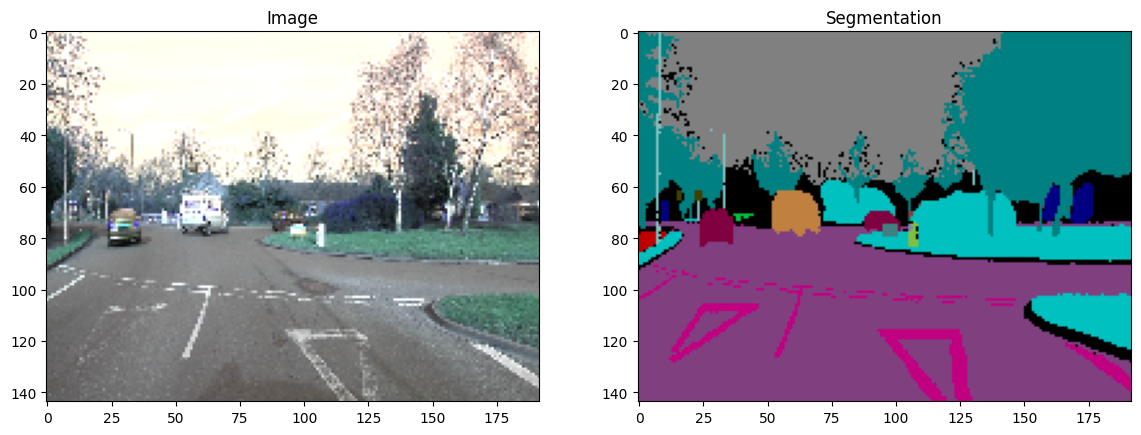

In [52]:
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(PILimage(images[0]))
arr[0].set_title('Image')
arr[1].imshow(PILimage(seg_images[0]))
arr[1].set_title('Segmentation')

## **Dataset**

In [63]:
class CamVidDataset(Dataset):
  def __init__(self, x, y, transform=None, target_transform=None):
    self.imgs = x
    self.seg_imgs = y
    self.len = len(x)
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    image = self.imgs[idx]
    seg_image = self.seg_imgs[idx]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, seg_image



In [64]:
CamVid = CamVidDataset(x=images, y=seg_images)

In [69]:
dataset = {}
dataset['train'], dataset['valid'], dataset['test'] = random_split(CamVid, [0.8, 0.1, 0.1])
len(dataset['train']), len(dataset['valid']), len(dataset['test'])

(561, 70, 70)

In [70]:
batch_size=64
dataloader = {}

dataloader['train'] = DataLoader(dataset['train'], batch_size=batch_size, shuffle=False)
dataloader['valid'] = DataLoader(dataset['valid'], batch_size=batch_size, shuffle=False)
dataloader['test'] = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False)

# **Model**

## **Train**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, dataloader, dataloader_size, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 20)

    # Each epoch has a training and validation phase
    for phase in ['train', 'valid']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0
      # running_acc = 0.0

      # Iterate over data.
      for inputs, labels in dataloader[phase]:
        inputs = inputs.to(device)
        labels = labels.type(torch.LongTensor).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          # acc = binary_accuracy(outputs.reshape(outputs.shape[0]), labels.reshape(labels.shape[0]), threshold=0.5)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        # running_acc += acc

        # if phase == 'train':
        #   scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      # epoch_acc = running_acc / dataset_sizes[phase]

      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

      # deep copy the model
      if phase == 'valid' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

## **Evaluate**

In [ ]:
def evaluate_model(model, criterion, dataloader, dataloader_size):
  since = time.time()

  print('-' * 20)

  # Each epoch has a training and validation phase
  model.eval()   # Set model to evaluate mode

  running_loss = 0.0
  running_corrects = 0
  # running_acc = 0.0

  # Iterate over data.
  for inputs, labels in dataloader['test']:
    inputs = inputs.to(device)
    labels = labels.type(torch.LongTensor).to(device)

    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

  eval_loss = running_loss / dataset_sizes['test']
  eval_acc = running_corrects.double() / dataset_sizes['test']

  print(f'test Loss: {eval_loss:.4f} Acc: {eval_acc:.4f}')

## **VGG16**

In [ ]:
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.classifier

## **Encoder**

In [71]:
input_size = images[0].shape
input_size

torch.Size([3, 144, 192])